In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import sys
from pathlib import Path
# from my_kalman_filter import * 

# Extract manually input data from Excel

In [16]:
path = './data'

def list_files_with_extension(directory, extension):
    return [str(f) for f in Path(directory).glob(f'*{extension}') if f.is_file()]

In [17]:
excel_files = list_files_with_extension(path, '.xlsx')
if excel_files:
    excel_file = excel_files[0]
    df_excel = pd.read_excel(excel_file, sheet_name='All_Data')
else:
    df_excel = None

# Drop the 3rd column (index 2)
df_excel_clean = df_excel.drop(df_excel.columns[2], axis=1)

# Forward-fill the last column to propagate condition labels
df_excel_clean[df_excel_clean.columns[-1]] = df_excel_clean[df_excel_clean.columns[-1]].ffill()

# Rename the 3rd column to 'condition'
df_excel_clean = df_excel_clean.rename(columns={df_excel_clean.columns[2]: 'condition'})

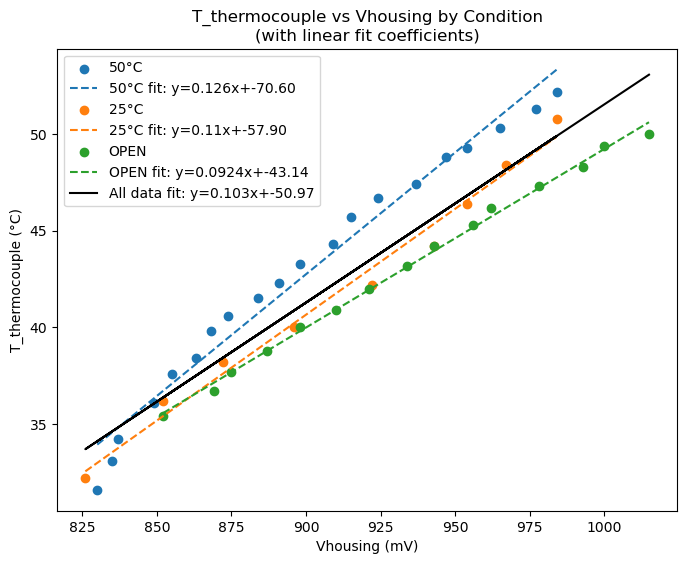

In [4]:
plt.figure(figsize=(8, 6))
colors = {'50°C': 'tab:blue', '25°C': 'tab:orange', 'OPEN': 'tab:green'}
unique_conditions = df_excel_clean['condition'].unique()

for cond in unique_conditions:
    mask = df_excel_clean['condition'] == cond
    x = df_excel_clean.loc[mask, 'Vhousing']
    y = df_excel_clean.loc[mask, 'T_thermocouple']
    plt.scatter(x, y, label=cond, color=colors.get(cond, None))
    # Linear regression for this condition
    if len(x) > 1:
        model = LinearRegression()
        model.fit(x.values.reshape(-1, 1), y.values)
        slope = model.coef_[0]
        intercept = model.intercept_
        plt.plot(x, model.predict(x.values.reshape(-1, 1)), color=colors.get(cond, None), linestyle='--',
                 label=f"{cond} fit: y={slope:.3g}x+{intercept:.2f}")

# Linear regression for all data
x_all = df_excel_clean['Vhousing'].values.reshape(-1, 1)
y_all = df_excel_clean['T_thermocouple'].values
model_all = LinearRegression()
model_all.fit(x_all, y_all)
slope_all = model_all.coef_[0]
intercept_all = model_all.intercept_
plt.plot(df_excel_clean['Vhousing'], model_all.predict(x_all), color='k', linestyle='-',
         label=f"All data fit: y={slope_all:.3g}x+{intercept_all:.2f}")

plt.xlabel('Vhousing (mV)')
plt.ylabel('T_thermocouple (°C)')
plt.legend()
plt.title('T_thermocouple vs Vhousing by Condition\n(with linear fit coefficients)')
plt.show()

In [5]:
# Mask for 'OPEN' condition in df_excel_clean
mask_open = df_excel_clean['condition'] == 'OPEN'
x_open = df_excel_clean.loc[mask_open, 'Vhousing'].values.reshape(-1, 1)
y_open = df_excel_clean.loc[mask_open, 'T_thermocouple'].values

# Fit linear regression for OPEN data
model_open = LinearRegression()
model_open.fit(x_open, y_open)
slope_open = model_open.coef_[0]
intercept_open = model_open.intercept_

# Import the Display Readings

In [6]:
def extract_data_inline(filename):
    """
    Extract data from a text file generated by makerplot or equivalent, mimicking the MATLAB behavior.
    Handles different versions of file structures.
   
    Args:
        filename: The text file containing the data to extract.
       
    Returns:
        idx_start: Index of start of burn.
        idx_stop: Index of stop of burn.
        delta_time: Median time difference between records.
        T : List of different temperatures
        X : List of different data used in the regression for calibration
    """
    # Read the data file (assuming it is comma or tab-delimited)
    data = pd.read_table(filename, header=None, delimiter=',')  # Use '\t' if it's tab-delimited
   
    # Determine the structure of the file based on the number of columns
    num_columns = data.shape[1]
   
    #print("Number of columns in the file:", num_columns)
    if num_columns == 16:
        column_names = ['time', 'seconds', 'empty', 'refl_power', 'T_spike', 'T_ref', 'avg_temp', 'flag_power', 'luxtron_2',
                        'T_display', 'Ant_Ref', 'Antenna_nb', 'PowerFwd', 'V_ref', 'V_rad', 'V_spike']
        data.columns = column_names
       
    elif  num_columns== 32 and data.iloc[0, 2] == ' ' :
        column_names = ['time', 'seconds','Empty', 'V_rad_short','V_housing','V_rad_tot',
            'T_spike','T_housing','T_diode','T_tissue','Ant_ref','reflPower','FwdPower','flag_power','setpower',
            'Antenna_nb','cathstatus', 'RefSlope','RefOffset','T_cable','RadSlope','RadOffset','HousingSlope',
            'Housingoffset','PwrSlope','PwrOffset','SwitchLoss','AntLoss','SpikeSlope','Spikeoffset','T_coef','zeros']
        data.columns = column_names
 
    elif  num_columns== 32 and not pd.isna(data.iloc[0, 2]) : #Rev5 inline coax, propeller v93
        column_names = ['time', 'seconds', 'V_rad_short','V_housing','V_rad_tot',
            'T_spike','T_housing','T_diode','T_tissue','T_cable','reflPower','FwdPower','flag_power','setpower',
            'Antnum','cathstatus','T_ant','T_short','FTcable','RadSlope','RadOffset','HousingSlope',
            'Housingoffset','PwrSlope','PwrOffset','SwitchLoss','AntLoss','SpikeSlope','Spikeoffset','T_coef','VTC2',
            'cooling_flag']
        data.columns = column_names
 
    elif  num_columns== 33 and not pd.isna(data.iloc[0, 2]) : #Rev5 inline coax, propeller v93
        column_names = ['time', 'seconds', 'V_rad_short','V_housing','V_rad_tot',
            'T_spike','T_housing','T_diode','T_tissue','T_cable','reflPower','FwdPower','flag_power','setpower',
            'Antnum','cathstatus','T_ant','T_short','FTcable','RadSlope','RadOffset','HousingSlope',
            'Housingoffset','PwrSlope','PwrOffset','SwitchLoss','AntLoss','SpikeSlope','Spikeoffset','T_coef','VTC2',
            'cooling_flag_1','cooling_flag_2']
        data.columns = column_names
 
    # Extract the temperature and power data based on antenna type
    antena_type = "spike"  # Assuming the antenna type is known for simplicity
   
    if antena_type == "spike":
        T_antenna = data['T_spike'].to_numpy()
        flag_power = data['flag_power']
    else:
        T_antenna = data['T_ref'].to_numpy()
        flag_power = data['flag_power'] if num_columns != 16 else data['luxtron_2']
 
    # Identify start and stop indices for the burn
    idx_start = np.where(np.diff(np.insert(flag_power.values, 0, 0)) == 1)[0]
    idx_start = idx_start.tolist()
    idx_stop = np.where(np.diff(np.append(flag_power.values, 0)) == -1)[0]
    idx_stop = idx_stop.tolist()
 
    # Extract the Temperatures, Voltages and Power data
    V_rad_short = data['V_rad_short'].to_numpy()
    V_rad_tot = data['V_rad_tot'].to_numpy()
    V_housing = data['V_housing'].to_numpy()
    V_diode = data['T_diode'].to_numpy() / 0.2
    V_spike = ((data['T_spike'] - data['Spikeoffset']) / data['SpikeSlope'])* 1000
 
    T_diode = data['T_diode'].to_numpy()
    T_display = data['T_tissue'].to_numpy()
    T_housing = data['T_housing'].to_numpy()
 
    if 'cooling_flag_1' in data.columns :
        cooling_flag_1 = data['cooling_flag_1'].to_numpy()
    else :
        cooling_flag_1 = [float('nan') for k in range (len(data))]
 
    if 'cooling_flag_2' in data.columns :
        cooling_flag_2 = data['cooling_flag_2'].to_numpy()
    else :
        cooling_flag_2 = [float('nan') for k in range (len(data))]
 
    power = data['FwdPower'] * (data['flag_power'] > 0).astype(float)  # Power only during active flag_power
    delta_time = np.median(np.diff(data['seconds'].values))
 
    # Create dataframe for temperatures and regression parameters
    X = pd.DataFrame({'V_rad_short' : V_rad_short, 'V_rad_tot' : V_rad_tot, 'V_spike' : V_spike, 'V_housing' : V_housing, 'V_diode' : V_diode, 'cooling_flag_1' : cooling_flag_1, 'cooling_flag_2' : cooling_flag_2, 'power' : power})
    T = pd.DataFrame({'T_antenna' : T_antenna, 'T_diode' : T_diode, 'T_housing' : T_housing, 'T_display' : T_display})
   
    return idx_start, idx_stop, delta_time, T, X

In [7]:
txt_files = list_files_with_extension(path, '.txt')

In [8]:
# Add a 'time_index' column before concatenating all_X
all_X = []

for file in txt_files:
    # Extract condition (text after last underscore, before .txt)
    condition = Path(file).stem.split('_')[-1]
    # Extract data
    _, _, _, _, X_local = extract_data_inline(file)
    # Drop unwanted columns
    X_local = X_local.drop(columns=['cooling_flag_1', 'cooling_flag_2', 'power'])
    # Add time_index column
    X_local = X_local.copy()
    X_local['time_index'] = X_local.index
    # Add condition column
    X_local['condition'] = condition
    all_X.append(X_local)

all_X = pd.concat(all_X, ignore_index=True)

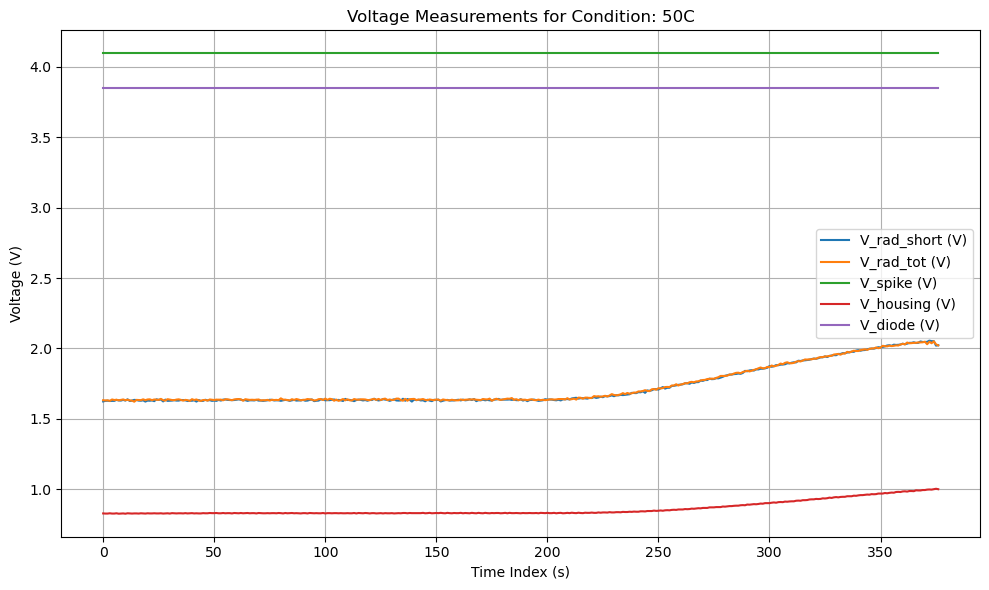

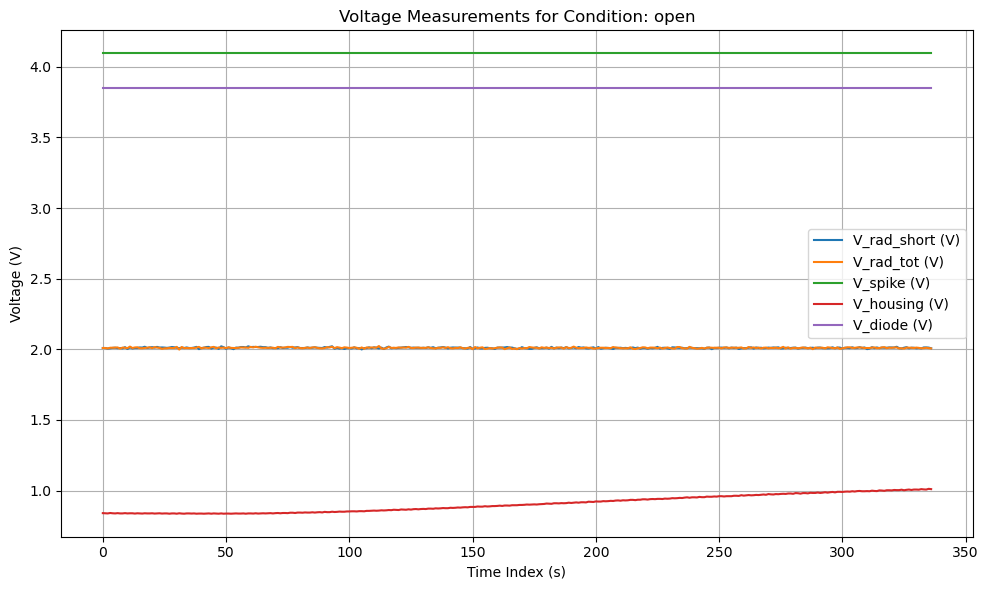

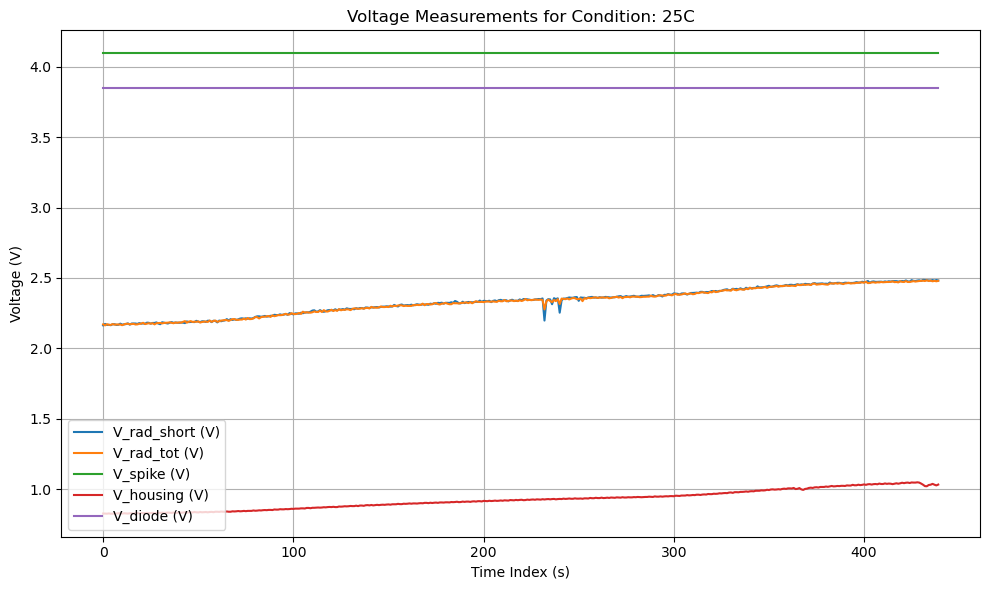

In [9]:
# Plot V_rad_short, V_rad_tot, V_spike, V_housing, V_diode vs sample index for each condition

variables = ['V_rad_short', 'V_rad_tot', 'V_spike', 'V_housing', 'V_diode']
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_spike': 'V_spike (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)'
}

for cond in all_X['condition'].unique():
    subset = all_X[all_X['condition'] == cond]
    plt.figure(figsize=(10, 6))
    for var in variables:
        plt.plot(subset.time_index, subset[var] / 1000, label=labels[var])
    plt.title(f"Voltage Measurements for Condition: {cond}")
    plt.xlabel("Time Index (s)")
    plt.ylabel("Voltage (V)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Radiometer Calibration

In [10]:
# Save the intercept and slope from the OPEN condition linear regression
open_slope = slope_open
open_intercept = intercept_open

def derive_t_housing_from_v_housing(v_housing):
    """
    Derive T_housing from V_housing using the OPEN condition linear regression.
    """
    return open_slope * v_housing + open_intercept

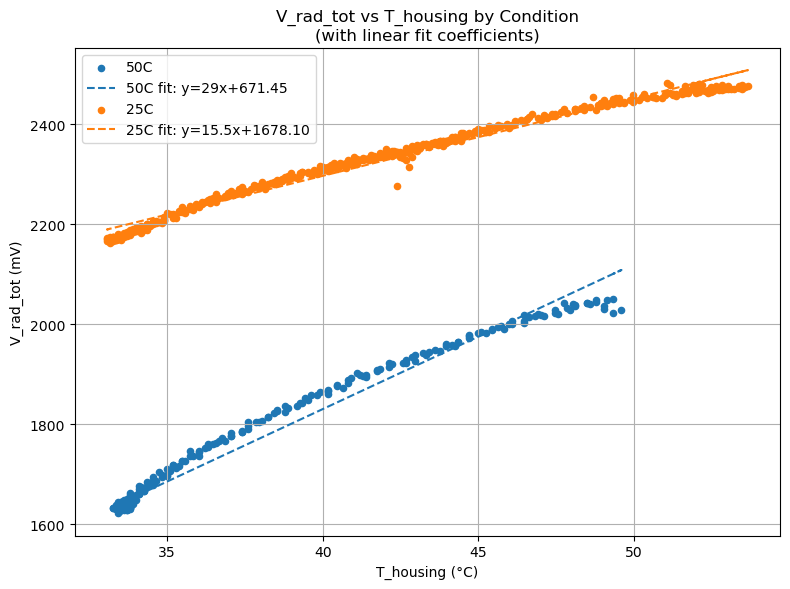

In [11]:
plt.figure(figsize=(8, 6))
for cond in all_X['condition'].unique():
    if cond == 'open':
        continue
    subset = all_X[all_X['condition'] == cond]
    # Calculate T_housing using the calibration function
    T_housing = derive_t_housing_from_v_housing(subset['V_housing'])
    # Plot V_rad_tot vs T_housing with smaller dots (no -2000 subtraction)
    plt.scatter(T_housing, subset['V_rad_tot'], label=cond, color=colors.get(cond, None), s=20)
    # Linear regression for this condition
    x_curve = T_housing.values.reshape(-1, 1)
    y_curve = subset['V_rad_tot'].values
    if len(x_curve) > 1:
        model_curve = LinearRegression()
        model_curve.fit(x_curve, y_curve)
        slope_curve = model_curve.coef_[0]
        intercept_curve = model_curve.intercept_
        plt.plot(T_housing, model_curve.predict(x_curve), color=colors.get(cond, None), linestyle='--',
                 label=f"{cond} fit: y={slope_curve:.3g}x+{intercept_curve:.2f}")
plt.xlabel('T_housing (°C)')
plt.ylabel('V_rad_tot (mV)')
plt.title('V_rad_tot vs T_housing by Condition\n(with linear fit coefficients)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# Generate cond_25 and cond_50 DataFrames from all_X
cond_25 = all_X[all_X['condition'].str.lower() == '25c']
cond_50 = all_X[all_X['condition'].str.lower() == '50c']

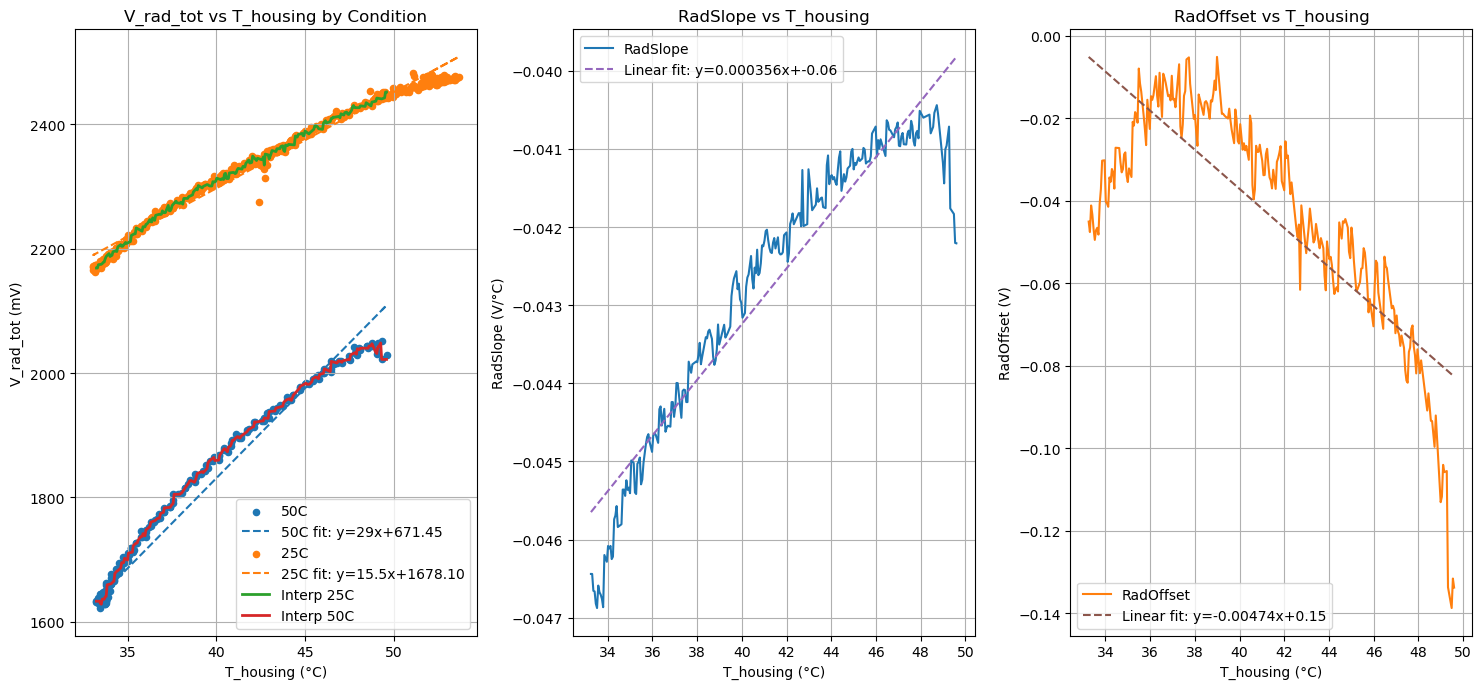

In [13]:

# Calculate shared T_housing range between 25C and 50C conditions with 300 points
T_25 = derive_t_housing_from_v_housing(cond_25['V_housing'])
T_50 = derive_t_housing_from_v_housing(cond_50['V_housing'])

T_min = max(T_25.min(), T_50.min())
T_max = min(T_25.max(), T_50.max())
T_shared = np.linspace(T_min, T_max, 300)

# Interpolate V_rad_tot for both conditions at shared T_housing
V_25_interp = np.interp(T_shared, T_25, cond_25['V_rad_tot'].values)
V_50_interp = np.interp(T_shared, T_50, cond_50['V_rad_tot'].values)

# Calculate RadSlope and RadOffset for each shared temperature
RadSlope = (2*(V_50_interp - V_25_interp) / 50-25) * 1e-3  # Convert to V/°C
RadOffset = - (25 - T_shared) * RadSlope + 2 * V_25_interp / 1000 - 4  # Offset at 25C, covert to V

# Linear regression for RadSlope vs T_housing
model_rs = LinearRegression()
model_rs.fit(T_shared.reshape(-1, 1), RadSlope)
rs_slope = model_rs.coef_[0]
rs_intercept = model_rs.intercept_

# Linear regression for RadOffset vs T_housing
model_ro = LinearRegression()
model_ro.fit(T_shared.reshape(-1, 1), RadOffset)
ro_slope = model_ro.coef_[0]
ro_intercept = model_ro.intercept_

# Plot: previous plot, RadSlope, RadOffset
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

# 1. Previous plot: V_rad_tot vs T_housing by Condition + interpolation
for cond in all_X['condition'].unique():
    if cond.lower() == 'open':
        continue
    subset = all_X[all_X['condition'] == cond]
    T_housing_cond = derive_t_housing_from_v_housing(subset['V_housing'])
    axes[0].scatter(T_housing_cond, subset['V_rad_tot'], label=cond, color=colors.get(cond, None), s=20)
    x_curve = T_housing_cond.values.reshape(-1, 1)
    y_curve = subset['V_rad_tot'].values
    if len(x_curve) > 1:
        model_curve = LinearRegression()
        model_curve.fit(x_curve, y_curve)
        slope_curve = model_curve.coef_[0]
        intercept_curve = model_curve.intercept_
        axes[0].plot(T_housing_cond, model_curve.predict(x_curve), color=colors.get(cond, None), linestyle='--',
                     label=f"{cond} fit: y={slope_curve:.3g}x+{intercept_curve:.2f}")
# Add interpolated curves
axes[0].plot(T_shared, V_25_interp, color='tab:green', linestyle='-', linewidth=2, label='Interp 25C')
axes[0].plot(T_shared, V_50_interp, color='tab:red', linestyle='-', linewidth=2, label='Interp 50C')
axes[0].set_xlabel('T_housing (°C)')
axes[0].set_ylabel('V_rad_tot (mV)')
axes[0].set_title('V_rad_tot vs T_housing by Condition')
axes[0].legend()
axes[0].grid(True)

# 2. RadSlope plot + regression
axes[1].plot(T_shared, RadSlope, color='tab:blue', label='RadSlope')
axes[1].plot(T_shared, model_rs.predict(T_shared.reshape(-1, 1)), color='tab:purple', linestyle='--',
             label=f'Linear fit: y={rs_slope:.3g}x+{rs_intercept:.2f}')
axes[1].set_xlabel('T_housing (°C)')
axes[1].set_ylabel('RadSlope (V/°C)')
axes[1].set_title('RadSlope vs T_housing')
axes[1].legend()
axes[1].grid(True)

# 3. RadOffset plot + regression
axes[2].plot(T_shared, RadOffset, color='tab:orange', label='RadOffset')
axes[2].plot(T_shared, model_ro.predict(T_shared.reshape(-1, 1)), color='tab:brown', linestyle='--',
             label=f'Linear fit: y={ro_slope:.3g}x+{ro_intercept:.2f}')
axes[2].set_xlabel('T_housing (°C)')
axes[2].set_ylabel('RadOffset (V)')
axes[2].set_title('RadOffset vs T_housing')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# T housing versus time

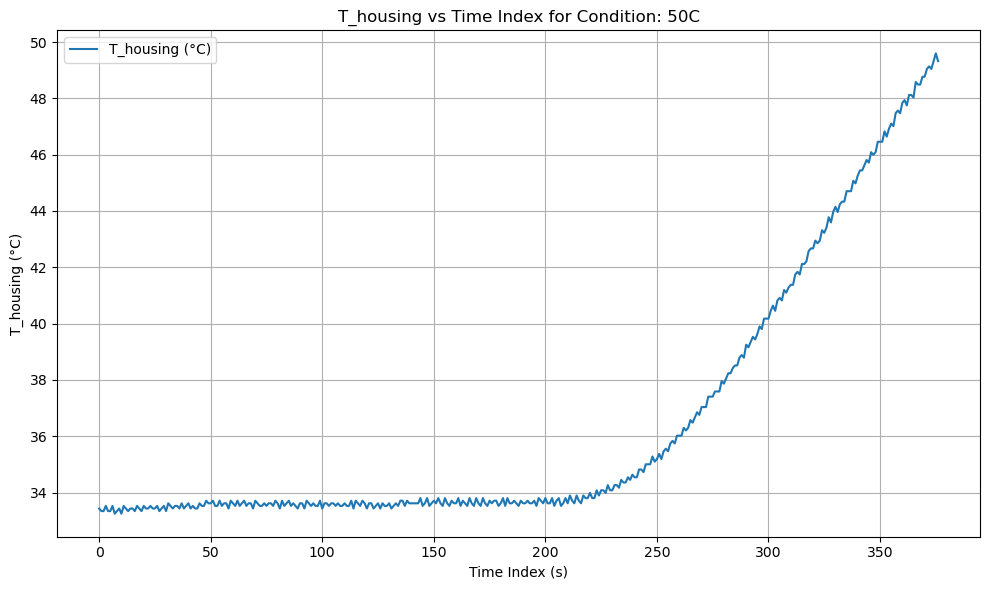

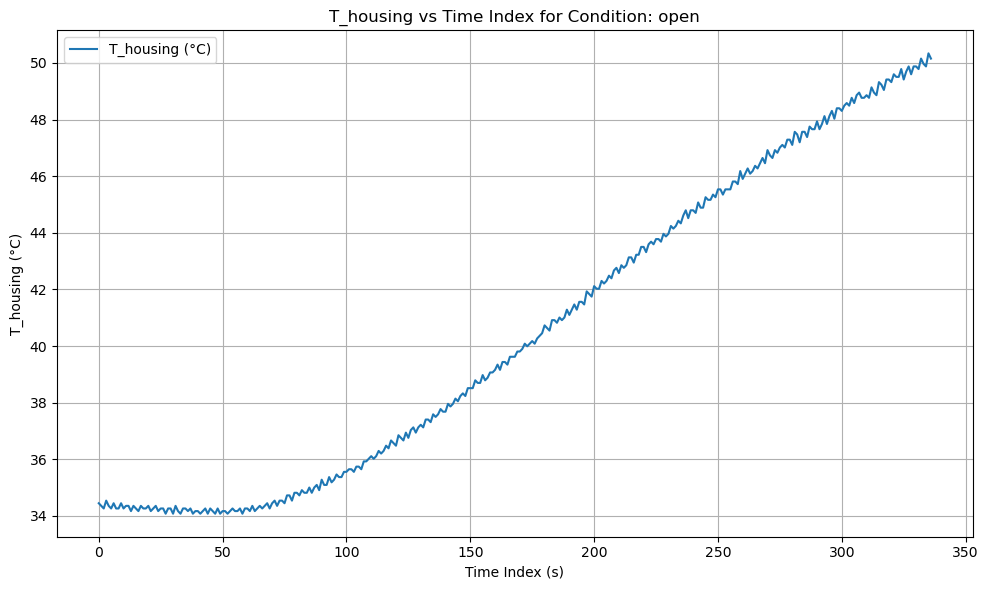

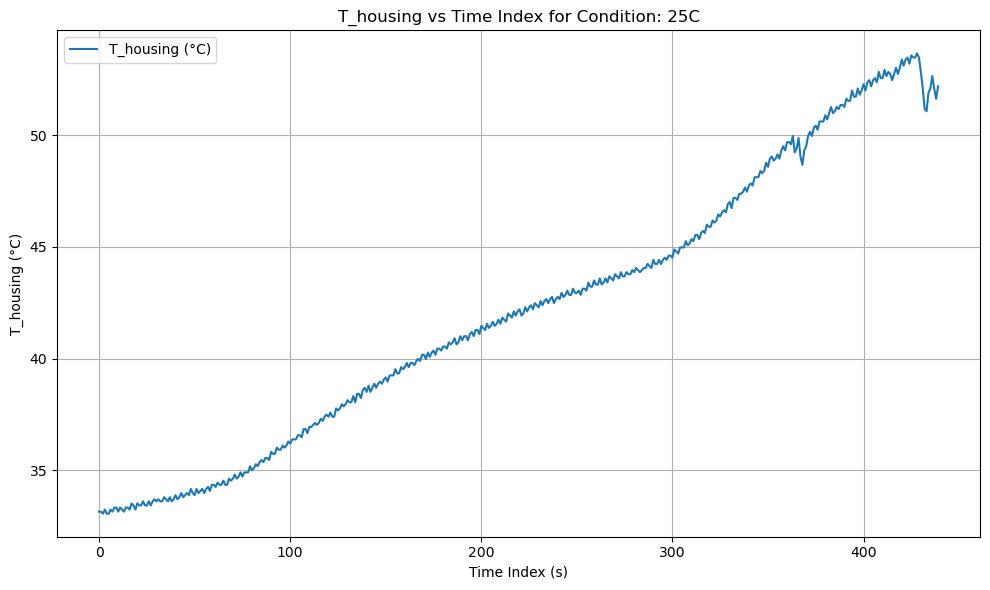

In [14]:
# Plot T_housing vs sample index for each condition using derive_t_housing_from_v_housing

for cond in all_X['condition'].unique():
    subset = all_X[all_X['condition'] == cond]
    plt.figure(figsize=(10, 6))
    # Calculate T_housing for each sample
    T_housing = derive_t_housing_from_v_housing(subset['V_housing'])
    plt.plot(subset.time_index, T_housing, label='T_housing (°C)')
    plt.title(f"T_housing vs Time Index for Condition: {cond}")
    plt.xlabel("Time Index (s)")
    plt.ylabel("T_housing (°C)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()